##### Modelo SEIR (Susceptibles, Expuestos, Infectados, Detectados, Recuperados, Fallecidos) + Contact Tracing

In [1]:
import numpy as np
import scipy
import scipy.integrate
import lmfit

from utilidades import *

def seir_model(SEIR, beta, sigma, gamma, mu, theta=0, beta_d=0, omega=0):
    S, E, C, I, D, R, F = SEIR

    # Poblacion
    N = S + E + C + I + D + R

    # - Los susceptibles que pasan a expuestos a razon `beta` (infectados no detectados)
    # - Los susceptibles que pasan a expuestos a razon `beta_d` (infectados detectados)
    dS = - beta * S * I / N - beta_d * S * D / N
    # + Los susceptibles que pasan a expuestos a razon `beta` (infectados no detectados)
    # - Los expuestos que pasan a infectados a razon `sigma`
    dE = beta * S * I / N - sigma * E
    # + Los susceptibles que pasan a expuestos a razon `beta_d` (infectados detectados)
    # - Los expuestos que pasan a infectados o detectados a razon `sigma`
    dC = beta_d * S * D / N - sigma * C
    # + Los expuestos que pasan a infectados no detectados a razon `sigma`
    # - Los contactos que pasan a infectados a razon `sigma * (1 - omega)`
    # - Los infectados no detectados que pasan a recuperados a razon `gamma`
    # - Los infectados no detectados que pasan a fallecidos a razon `mu`
    # - Los infectados no detectados que pasan a detectados a razon `theta`
    dI = sigma * E + (1 - omega) * sigma * C - gamma * I - mu * I - theta * I
    # + Los infectados no detectados que pasan a detectados a razon `theta`
    # - Los contactos que pasan a infectados a razon `sigma * omega`
    # - Los detectados que pasan a recuperados a razon `gamma`
    # - Los detectados que pasan a fallecidos a razon `mu`
    dD = theta * I + omega * sigma * C - gamma * D - mu * D
    # + Los infectados no detectados que pasan a recuperados a razon `gamma`
    # + Los detectados que pasan a recuperados a razon `gamma`
    dR = gamma * I + gamma * D
    # + Los infectados no detectados que pasan a fallecidos a razon `mu`
    # + Los detectados que pasan a fallecidos a razon `mu`
    dF = mu * I + mu * D

    return [
        dS, dE, dC, dI, dD, dR, dF
    ]

Clases:
    * Susceptible
    * Expuesto
    * Infectado
    * Detectado - Infectado Detectado
    * Recuperado
    * Fallecido
Nueva Clase:
    * Contacto - Expuesto Detectado
    
Parametros:  
    * `beta` es la razon de transmision  
    * `sigma` es la razon de transicion de Expuesto a Infectado  
    * `gamma` es la razon de transicion de Infectado a Recuperado (o aislado)  
    * `mu` es la razon de transicion de Infectado a Fallecido
    * `theta` es la razon de transicion de Infectado a Detectado  
    * `beta_d` es la razon de transmision de los Detectados  
Nuevos Parametros:  
    * `omega` por ahora es el % de efectividad de la medidad de seguimiento de contactos


Notas:
* `omega` esta relacionado a la definicion de contacto y a la capacidad de hacer ese seguimiento

In [2]:
periodo_incubacion = 5.2
periodo_infeccioso = 12.4
razon_mortalidad = 3.4 / 100.0 # OMS, best fit

infectados_t0 = 16. # Best fit
susceptibles_t0 = 11e6

data = load_data()

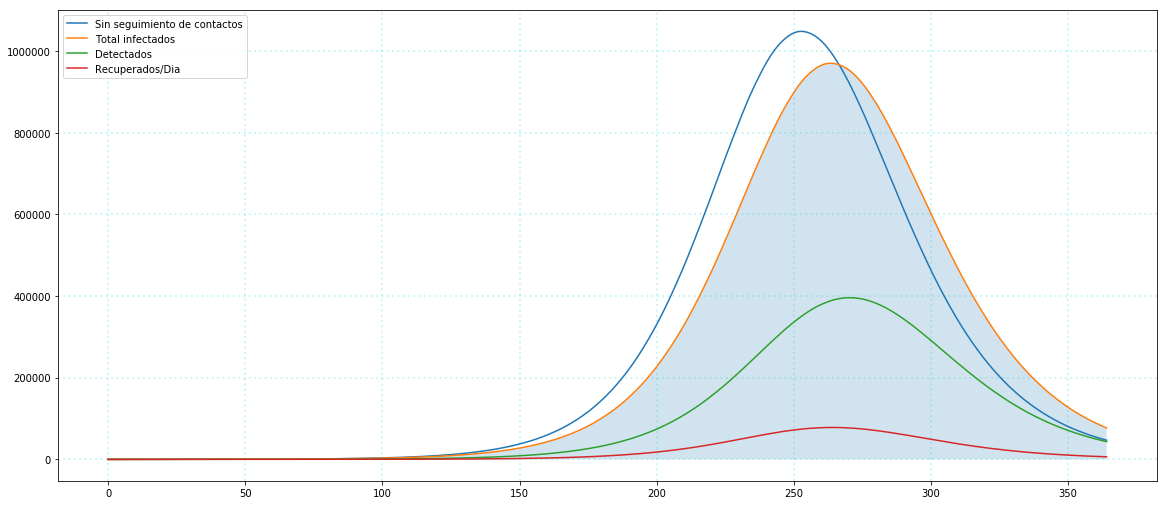

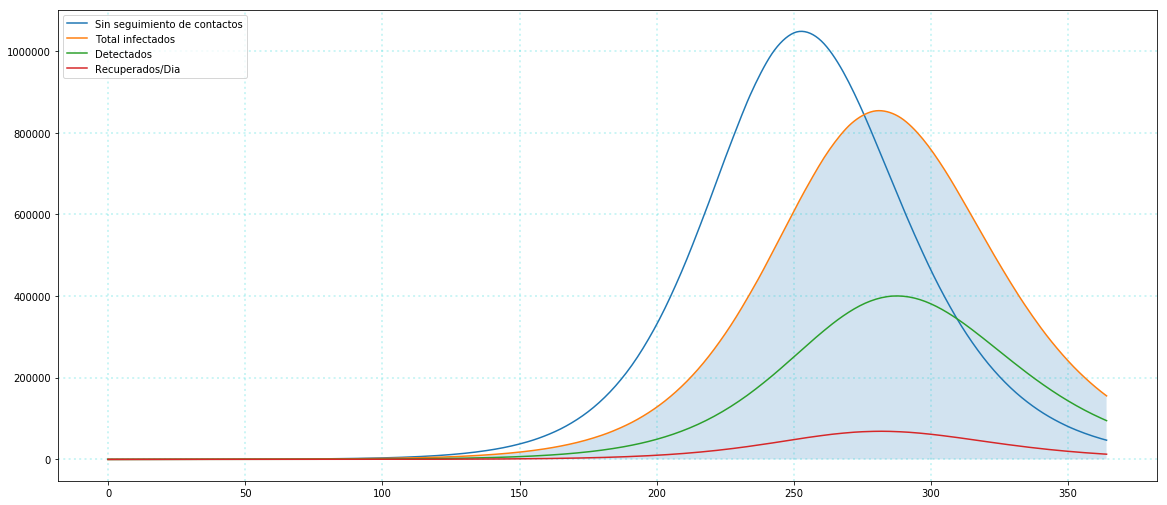

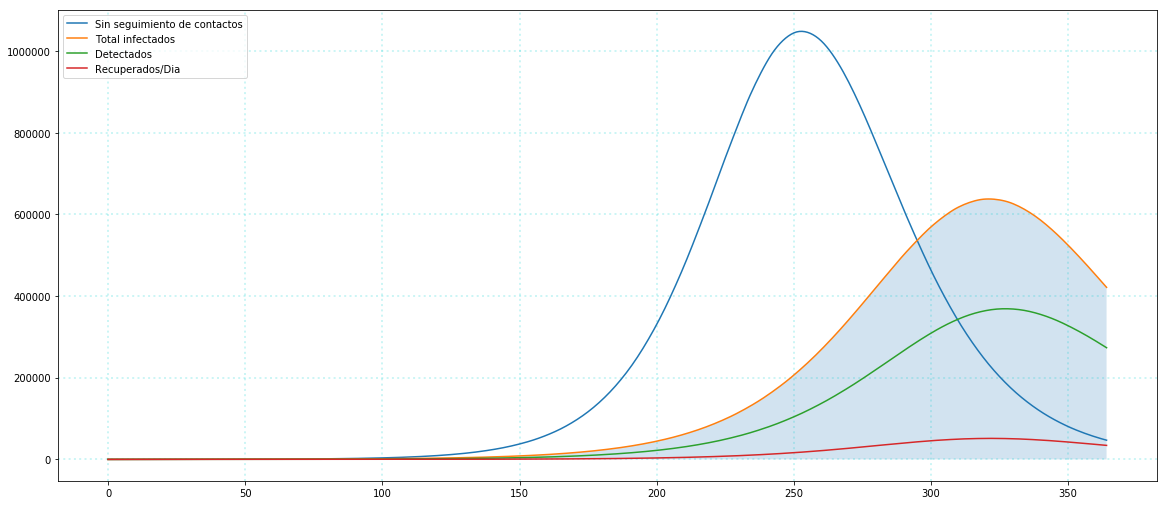

In [12]:
def run_model(params):
    if type(params) == lmfit.Parameters:
        params = [param.value for param in params.values()]
        
    R0, theta, R_D, omega = params
    
    SEIR_t0 = (
        susceptibles_t0,
        infectados_t0 * R0, # expuestos
        0, # contactos
        infectados_t0,
        0, 0, 0 # detectados, recuperados, fallecidos
    )
    return run(
        seir_model,
        SEIR_t0,
        beta = R0 / periodo_infeccioso,
        sigma = 1. / periodo_incubacion,
        gamma = 1. / periodo_infeccioso,
        mu = razon_mortalidad / periodo_infeccioso,
        theta = theta,
        beta_d = R_D / periodo_infeccioso,
        omega = omega,
        days = days,
        step = 1
    )

days = 365

solutions = [
    (var, run_model((2.4, .05, 1., var))) for var in (
        np.arange(start=0., stop=1., step=0.04)
    )
]

solutions_x = solutions[0][1]['t']
solutions = [(var, sol['y'][4], sol['y'][4] + sol['y'][3], sol['y'][5], sol['y'][2]) for var, sol in solutions]
var, sol_d, sol_it, sol_r, sol_c = zip(*solutions)
sol_r = [np.diff(_, prepend=[_[0]]) for _ in sol_r]

for _ in range(1, 4):
    _ = _ * 8
    ax = plot(solutions_x, sol_it[0], labels=['Sin seguimiento de contactos'])
    ax.plot(solutions_x, sol_it[_], label='Total infectados')
    ax.plot(solutions_x, sol_d[_], label='Detectados')
    ax.plot(solutions_x, sol_r[_], label='Recuperados/Dia')
    ax.fill_between(
        solutions_x,
        [0] * len(solutions_x),
        sol_it[_],
        alpha=0.2
    )
    ax.legend(loc='upper left')

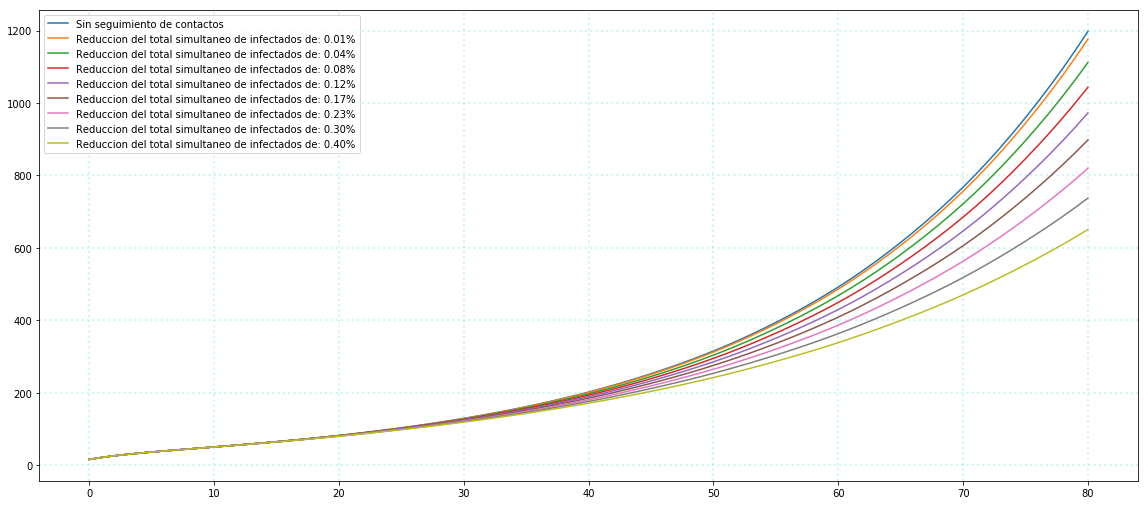

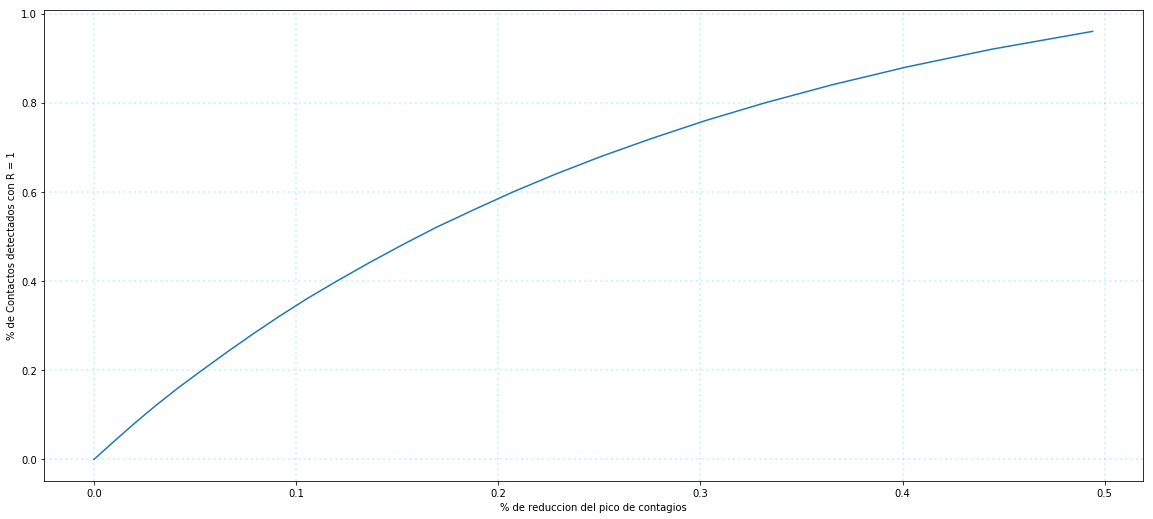

In [4]:
to_day = len(data[0]) + 30
solutions_x_capped = solutions_x[:to_day]

ax = plot(solutions_x_capped, sol_it[0][:to_day], labels=['Sin seguimiento de contactos'])

for _ in range(1, len(solutions), 3):
    ax.plot(
        solutions_x_capped, 
        sol_it[_][:to_day], 
        label='Reduccion del total simultaneo de infectados de: {:.2f}%'. format(
            1 - max(sol_it[_] / max(sol_it[0]))
        )
    )
    ax.legend(loc='upper left')


fig, ax = pyplot.subplots()

reduction_concurrent_infected = [1 - max(sol_it[_] / max(sol_it[0])) for _ in range(len(solutions))]

ax.plot(reduction_concurrent_infected, np.arange(start=0., stop=1., step=0.04))
ax.set(xlabel='% de reduccion del pico de contagios', ylabel='% de Contactos detectados con R = 1')
pyplot.grid(b=True, color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)

Este si no parece estar funcando